In [63]:
import polars as pl
import matplotlib.pyplot as plt
import blitzbeaver as bb
from blitzbeaver.tracking_graph import (
    MaterializedTrackerFrame,
    MaterializedTrackingChain,
    TrackerFrameDiagnostics,
    RecordSchema,
)
from blitzbeaver.literals import ID
import random
from Levenshtein import distance
import json

In [64]:
csv_path = "../../aptihramy/data/csv_cleaned"
beaver_folder_path = "../beaver_files"
json_folder_path = "../json_files"
verifier_dropped_cols = ["frame_idx", "enfants_chez_parents_prenom"]

In [65]:
dataframes_35_45 = [
    pl.read_csv(f"{csv_path}/{year}.csv", infer_schema_length=10000)
    for year in range(1835, 1845 + 1)
]

dataframes_60_70 = [
    pl.read_csv(f"{csv_path}/{year}.csv", infer_schema_length=10000)
    for year in range(1860, 1870 + 1)
]

dataframes_87_97 = [
    pl.read_csv(f"{csv_path}/{year}.csv", infer_schema_length=10000)
    for year in range(1887, 1897 + 1)
]

In [66]:
def clean_children(dataframes: pl.DataFrame) -> pl.DataFrame:
    for i in range(len(dataframes)):
        df = dataframes[i]
        dataframes[i] = df.with_columns(
            df["enfants_chez_parents_prenom"]
            .str.split("|")
            .list.eval(pl.element().filter(pl.element() != ""))
            .alias("enfants_chez_parents_prenom")
        )


clean_children(dataframes_35_45)
clean_children(dataframes_60_70)
clean_children(dataframes_87_97)

In [67]:
record_schema_base = bb.RecordSchema(
    [
        bb.FieldSchema("nom_rue", bb.ElementType.String),
        bb.FieldSchema("chef_prenom", bb.ElementType.String),
        bb.FieldSchema("chef_nom", bb.ElementType.String),
        bb.FieldSchema("chef_origine", bb.ElementType.String),
        bb.FieldSchema("epouse_nom", bb.ElementType.String),
        bb.FieldSchema("chef_vocation", bb.ElementType.String),
        bb.FieldSchema("enfants_chez_parents_prenom", bb.ElementType.MultiStrings),
    ]
)

In [68]:
record_schema_normalized = bb.RecordSchema(
    [
        bb.FieldSchema("nom_rue_norm", bb.ElementType.String),
        bb.FieldSchema("chef_prenom_norm", bb.ElementType.String),
        bb.FieldSchema("chef_nom_norm", bb.ElementType.String),
        bb.FieldSchema("chef_origine_norm", bb.ElementType.String),
        bb.FieldSchema("epouse_nom_norm", bb.ElementType.String),
        bb.FieldSchema("chef_vocation_norm", bb.ElementType.String),
        bb.FieldSchema("enfants_chez_parents_prenom", bb.ElementType.MultiStrings),
    ]
)

In [69]:
def distance_metric_config_to_dict(c: bb.DistanceMetricConfig):
    return {
        "metric:": c.metric,
        "caching_threshold": c.caching_threshold,
        "use_sigmoid": c.use_sigmoid,
        "lv_edit_weights": c.lv_edit_weights,
        "lv_substring_weight": c.lv_substring_weight,
        "lv_multiword_separator": c.lv_multiword_separator,
    }


def record_scorer_config_to_dict(c: bb.RecordScorerConfig):
    return {
        "record_scorer": c.record_scorer,
        "weights": c.weights,
        "min_weight_ratio": c.min_weight_ratio,
    }


def memory_config_to_dict(c: bb.MemoryConfig):
    return {
        "memory_strategy": c.memory_strategy,
        "multiword_threshold_match": c.multiword_threshold_match,
        "multiword_distance_metric": (
            None
            if c.multiword_distance_metric is None
            else distance_metric_config_to_dict(c.multiword_distance_metric)
        ),
    }


def resolver_config_to_dict(c: bb.ResolverConfig):
    return {"resolving_strategy": c.resolving_strategy}


def config_to_dict_test(c: bb.TrackingConfig):
    return {
        "distance_metric": distance_metric_config_to_dict(c.distance_metric),
        "resolver": resolver_config_to_dict(c.resolver),
        "interest_threshold": c.tracker.interest_threshold,
        "limit_no_match_streak": c.tracker.limit_no_match_streak,
        "memories": [memory_config_to_dict(a) for a in c.tracker.memories],
        "record_scorer": record_scorer_config_to_dict(c.tracker.record_scorer),
    }


def config_to_dict(c: bb.TrackingConfig):
    return {
        "distance_metric": distance_metric_config_to_dict(c.distance_metric),
        "resolver": resolver_config_to_dict(c.resolver),
        "interest_threshold": c.tracker.interest_threshold,
        "limit_no_match_streak": c.tracker.limit_no_match_streak,
        "record_scorer": record_scorer_config_to_dict(c.tracker.record_scorer),
        "memories": [memory_config_to_dict(a) for a in c.tracker.memories],
    }

In [70]:
# caching_threshold = range(1, 5)
caching_threshold = [4]
# use_sigmoids = [True, False]
use_sigmoids = [False]
lv_edit_weights = [
    [0.1, 0.5, 0.5],
    [0.2, 0.5, 0.5],
    [0.3, 0.5, 0.5],
    [0.1, 0.8, 0.8],
    [0.2, 0.8, 0.8],
    [0.3, 0.8, 0.8],
]
lv_substring_weights = [round(x * 0.2, 1) for x in range(1, 6)]

distance_metrics_lv_opti = [
    bb.DistanceMetricConfig(metric="lv_opti", caching_threshold=c, use_sigmoid=s)
    for c in caching_threshold
    for s in use_sigmoids
]


distance_metric_edit = [
    bb.DistanceMetricConfig(
        metric="lv_edit",
        caching_threshold=c,
        use_sigmoid=s,
        lv_edit_weights=e,
    )
    for c in caching_threshold
    for s in use_sigmoids
    for e in lv_edit_weights
]


distance_metric_substring = [
    bb.DistanceMetricConfig(
        metric="lv_substring",
        caching_threshold=c,
        use_sigmoid=s,
        lv_substring_weight=w,
    )
    for c in caching_threshold
    for s in use_sigmoids
    for w in lv_substring_weights
]

distance_metric_multiword = [
    bb.DistanceMetricConfig(
        metric="lv_multiword",
        caching_threshold=c,
        use_sigmoid=s,
        lv_multiword_separator=" ",
    )
    for c in caching_threshold
    for s in use_sigmoids
]
# should add edit config
distance_metric_single_word = distance_metrics_lv_opti + distance_metric_substring

In [71]:
record_scorer_average = bb.RecordScorerConfig(
    record_scorer="average",
    weights=None,
    min_weight_ratio=None,
)

min_weight_ratios = [round(x * 0.2, 1) for x in range(1, 5)]
weights = [
    [
        0.2,
        0.25,
        0.25,
        0.25,
        0.15,
        0.2,
        0.1,
    ],
    [
        0.1,
        0.3,
        0.3,
        0.3,
        0.1,
        0.1,
        0.1,
    ],
    [
        0.1,
        0.5,
        0.5,
        0.5,
        0.1,
        0.1,
        0.1,
    ],
]


record_scorer_weight = [
    bb.RecordScorerConfig(
        record_scorer="weighted-average",
        weights=w,
        min_weight_ratio=ratio,
    )
    for w in weights
    for ratio in min_weight_ratios
]

record_scorer = [record_scorer_average] + record_scorer_weight

In [72]:
resolver_config = bb.ResolverConfig(
    resolving_strategy="best-match",
)

In [73]:
memory_strategies = [
    "bruteforce",
    "mostfrequent",
    "median",
    "ls-bruteforce",
    "ls-mostfrequent",
    "ls-median",
    "mw-mostfrequent",
    "mw-median",
]
memory_configs = [bb.MemoryConfig(memory_strategy=m) for m in memory_strategies]

multi_word_thresholds = [round(x * 0.2, 1) for x in range(1, 5)]

# multistring_memory_config = [
#     bb.MemoryConfig(
#         memory_strategy=m,
#         multiword_threshold_match=t,
#         multiword_distance_metric=d,
#     )
#     for m in memory_strategies
#     for t in multi_word_thresholds
#     for d in distance_metric_single_word
# ]

multistring_memory_config = [
    bb.MemoryConfig(
        memory_strategy="mw-median",
        multiword_threshold_match=t,
        multiword_distance_metric=d,
    )
    for t in multi_word_thresholds
    for d in distance_metrics_lv_opti
]

In [74]:
thresholds = [round(x * 0.2, 1) for x in range(1, 5)]
configs = [
    bb.config(
        record_schema=record_schema_base,
        distance_metric_config=d,
        record_scorer_config=r,
        resolver_config=resolver_config,
        memory_config=m,
        multistring_memory_config=mm,
        interest_threshold=t,
        limit_no_match_streak=4,
        num_threads=12,
    )
    for d in distance_metric_single_word
    for r in record_scorer
    for m in memory_configs
    for mm in multistring_memory_config
    for t in thresholds
]
print(len(configs))

9984


In [75]:
def aggregate_distance_averages(avgs: list[list[float]], nb_features: int):
    agg = [0] * nb_features

    for avg in avgs:

        for i, val in enumerate(avg):
            agg[i] += val

    return [v / len(avgs) for v in agg]


def avg_distance_metrics(
    graph: bb.TrackingGraph,
    dataframes: list[pl.DataFrame],
    record_schema: RecordSchema,
    id: ID,
) -> list[float] | None:
    """
    Computes the average distance per feature (column) across matching records in a tracker chain.

    For each frame in the tracker diagnostics, it identifies the record matching the materialized
    tracking chain and computes the average of the distance metrics per feature.

    Args:
        graph (bb.TrackingGraph): The tracking graph containing diagnostics.
        dataframes (list[pl.DataFrame]): List of Polars DataFrames used for materialization.
        record_schema (RecordSchema): The schema defining the order and number of features.
        id (ID): The tracker ID whose chain should be processed.

    Returns:
        list[float] | None: A list of average distances per feature. Returns None if the tracker
        doesn't exist or has no matching frames.
    """
    nb_features = len(record_schema.fields)
    tracker_diag = graph.diagnostics.get_tracker(id)

    if tracker_diag is None:
        return None

    materialized = graph.materialize_tracking_chain(id, dataframes, record_schema, None)

    avg = [0] * nb_features
    counts = [0] * nb_features

    # Map each frame index to the corresponding record index (excluding the first frame)
    frame_to_record = {
        m.frame_idx: m.record_idx for m in materialized.matched_frames[1:]
    }

    if len(frame_to_record) == 0:
        return None

    for frame in tracker_diag.frames:
        record_idx = frame_to_record.get(frame.frame_idx)
        if record_idx is None:
            continue

        for record in frame.records:
            if record.record_idx != record_idx:
                continue

            for i, distance in enumerate(record.distances):
                if distance is not None:
                    avg[i] += distance
                    counts[i] += 1
            break

    # Compute average for each feature
    ret = []
    for i, v in enumerate(avg):
        count = counts[i]
        if count == 0:
            count = 1
        ret.append(v / count)

    return ret


def print_column_scores(
    graph: bb.TrackingGraph, dataframes: list[pl.DataFrame], record_schema: RecordSchema
):
    print("Column scores:")
    avgs = [
        avg_distance_metrics(graph, dataframes, record_schema, id)
        for id in graph.trackers_ids
    ]

    agg_avgs = aggregate_distance_averages(
        [a for a in avgs if a is not None], len(record_schema.fields)
    )
    zipped = list(zip(record_schema.fields, agg_avgs))
    for schema, avg in zipped:
        print(f"{schema.name}: {avg}")

In [76]:
def find_chain_with_length(
    graph: bb.TrackingGraph, start_idx: int, length: int
) -> None | int:
    idx = start_idx
    while idx < len(graph.trackers_ids):
        tracker_id = graph.trackers_ids[idx]
        chain = graph._raw.get_tracking_chain(tracker_id)
        if len(chain) >= length:
            return tracker_id
        idx += 1
    return None


def take_n_random_ids(n: int, graph: bb.TrackingGraph, min_length: int) -> list[int]:
    # Filter only tracker IDs with chain length >= min_length
    valid_ids = [
        tracker_id
        for tracker_id in graph.trackers_ids
        if len(graph._raw.get_tracking_chain(tracker_id)) >= min_length
    ]

    # Adjust n if there are fewer valid IDs than requested
    n = min(n, len(valid_ids))

    return random.sample(valid_ids, n)


def print_verify_df(chain: MaterializedTrackingChain):
    values, columns = verify_columns_of_chain(chain)
    for i, v in enumerate(values):
        print(f"{columns[i]}: {v}")


def verify_columns_of_chain(
    chain: MaterializedTrackingChain,
) -> tuple[list[float], list[str]]:
    df = chain.as_dataframe().drop(verifier_dropped_cols)

    results = []
    for col in df.columns:
        results.append(verify_column(df[col].to_list()))

    return results, df.columns


def print_aggregate_verifiers(
    agg_values: list[float], fields: list[str]
) -> list[float]:
    print("Aggregated verifiers:")
    for i, r in enumerate(agg_values):
        print(f"{fields[i]}: {r}")


def aggregate_column_verifiers(l: list[list[float]]) -> list[float]:
    results = [0] * len(l[0])
    for values in l:
        for i, v in enumerate(values):
            results[i] += v

    return [v / len(l) for v in results]


def verify_column(l: list[str | None]) -> float:
    ratio = 0
    count = 0

    for i, value in enumerate(l[:-1]):
        next = l[i + 1]
        if value is None:
            value = ""
        if next is None:
            next = ""
        max_len = max(len(value), len(next))
        if max_len == 0:
            continue
        ratio += 1 - distance(value, next) / max_len
        count += 1

    if count == 0:
        return 0.0
    return ratio / count


def verify_n_samples(
    tracking_graph: bb.TrackingGraph,
    dataframes: list[pl.DataFrame],
    schema: RecordSchema,
    nb_samples: int,
    min_length: int,
) -> list[float]:
    ids = take_n_random_ids(nb_samples, tracking_graph, min_length)
    a = []

    for id in ids:
        chain = tracking_graph.materialize_tracking_chain(
            id, dataframes, schema, normalized_dataframes=None
        )
        values, _ = verify_columns_of_chain(chain)
        a.append(values)

    return aggregate_column_verifiers(a)


def print_verify_n_samples(
    tracking_graph: bb.TrackingGraph,
    dataframes: list[pl.DataFrame],
    schema: RecordSchema,
    nb_samples: int,
    min_length: int,
):
    r = verify_n_samples(tracking_graph, dataframes, schema, nb_samples, min_length)
    fields = [f.name for f in schema.fields if f.name not in verifier_dropped_cols]
    print_aggregate_verifiers(r, fields)

In [77]:
def aggregate_histograms(histograms: list[list[int]]) -> list[int]:
    """
    Aggregates a list of histograms into a single histogram.
    """
    max_len = max([len(h) for h in histograms])
    result = [0] * max_len
    for h in histograms:
        for i, v in enumerate(h):
            result[i] += v
    return result


def get_start_end_years(
    graph: bb.TrackingGraph,
    dataframes: list[pl.DataFrame],
    record_schema: RecordSchema,
    nb_of_years: int,
) -> tuple[list[int], list[int]]:

    start_years = [0] * nb_of_years
    end_years = [0] * nb_of_years
    for id in graph.trackers_ids:
        materialized = graph.materialize_tracking_chain(id, dataframes, record_schema)
        start_years[materialized.matched_frames[0].frame_idx] += 1
        end_years[materialized.matched_frames[-1].frame_idx] += 1

    return start_years, end_years


def get_avg_record_tracker_match(graph: bb.TrackingGraph):
    graph_metrics = bb.evaluate_tracking_graph_properties(graph._raw)

    records_match_ratios = graph_metrics.records_match_ratios[1:]
    trackers_match_ratios = graph_metrics.trackers_match_ratios[1:-1]

    avg_records_match = sum(records_match_ratios) / len(records_match_ratios)
    avg_trackers_match = sum(trackers_match_ratios) / len(trackers_match_ratios)

    return avg_records_match, avg_trackers_match


def summary_graph(
    graph: bb.TrackingGraph,
    show_graphs: bool,
    dataframes: list[pl.DataFrame],
    record_schema: RecordSchema,
    nb_of_years: int,
    conflict_nb: int,
):

    # compute the sum of the histograms for all frames
    histogram_records = aggregate_histograms(
        [
            resolving.histogram_record_matchs
            for resolving in graph.diagnostics.resolvings
        ]
    )
    # do not show beyond 10 elements as the counts are very low
    histogram_records = histogram_records
    histogram_trackers = aggregate_histograms(
        [
            resolving.histogram_tracker_matchs
            for resolving in graph.diagnostics.resolvings
        ]
    )
    histogram_trackers = histogram_trackers

    chain_metrics = bb.evaluate_tracking_chain_length(graph._raw)

    start_years, end_years = get_start_end_years(
        graph, dataframes, record_schema, nb_of_years
    )

    avg_records_match, avg_trackers_match = get_avg_record_tracker_match(graph)
    per_divergence = sum(histogram_trackers[conflict_nb:]) / sum(histogram_trackers[1:])
    per_conflict = sum(histogram_records[conflict_nb:]) / sum(histogram_records[1:])

    # total number of trackers created
    print(f"Number of chains: {len(graph.trackers_ids)}")
    # average percentage of records that have been match with an existing tracker
    print(f"Percentage of matching records: {avg_records_match*100:.2f}%")
    # average percentage of trackers that have match with a record of the current frame
    print(f"Percentage of matching trackers: {avg_trackers_match*100:.2f}%")
    # number of times a tracker matched with more that one record
    # divided by the number of times a tracker matched with a record
    print(f"Percentage of divergences: {per_divergence*100:.2f}%")
    # number of times a record matched with multiple trackers
    # divided by the number of times a record matched with a tracker
    print(f"Percentage of conflicts: {per_conflict*100:.2f}%")

    print(chain_metrics.histogram[1:])

    if not show_graphs:
        return

    plt.bar(range(1, len(chain_metrics.histogram)), chain_metrics.histogram[1:])
    plt.title("Histogram of tracking chain lengths")
    plt.show()

    plt.bar(range(len(start_years)), start_years)
    plt.title("Histogram of trackers starting years")
    plt.show()

    plt.bar(range(len(end_years)), end_years)
    plt.title("Histogram of trackers ending years")
    plt.show()

    plt.bar(range(len(histogram_records)), histogram_records)
    plt.title("Histogram of # matchs per record")
    plt.show()

    plt.bar(range(len(histogram_trackers)), histogram_trackers)
    plt.title("Histogram of # matchs per tracker")
    plt.show()

In [ ]:
def compute_and_save_beaver(
    config: bb.TrackingConfig,
    record_schema: bb.RecordSchema,
    dataframes: list[pl.DataFrame],
    filepath: str,
) -> bb.TrackingGraph:
    path_graph = f"{beaver_folder_path}/{filepath}"
    graph = bb.execute_tracking(config, record_schema, dataframes, "debug")
    bb.save_beaver(path_graph, graph)
    return graph


def save_json(filepath: str, d: dict[str, any]):
    path_json = f"{json_folder_path}/{filepath}"
    with open(path_json, "w") as f:
        json.dump(d, f, indent=2)


def build_tracking_summary(
    config: bb.TrackingConfig,
    record_schema: bb.RecordSchema,
    dataframes: list[pl.DataFrame],
    nb_samples: int,
    min_length: int,
    nb_of_years: int,
) -> dict[str, any]:

    all_dict = {}

    all_dict["config"] = config_to_dict(config)
    graph = bb.execute_tracking(config, record_schema, dataframes, "debug")

    r = verify_n_samples(graph, dataframes, record_schema, nb_samples, min_length)
    all_fields_names = [f.name for f in record_schema.fields]
    filtered_fields = [
        f_name for f_name in all_fields_names if f_name not in verifier_dropped_cols
    ]

    data_dict = {}
    data_dict["verifier"] = dict(zip(filtered_fields, r))

    avgs = [
        avg_distance_metrics(graph, dataframes, record_schema, id)
        for id in graph.trackers_ids
    ]

    agg_avgs = aggregate_distance_averages(
        [a for a in avgs if a is not None], len(all_fields_names)
    )

    data_dict["memory_distance"] = dict(zip(all_fields_names, agg_avgs))

    chain_metrics = bb.evaluate_tracking_chain_length(graph._raw)
    start_years, end_years = get_start_end_years(
        graph, dataframes, record_schema, nb_of_years
    )

    data_dict["start_years"] = start_years
    data_dict["end_years"] = end_years
    data_dict["chain_lengths"] = chain_metrics.histogram

    avg_records_match, avg_trackers_match = get_avg_record_tracker_match(graph)
    data_dict["avg_records_match"] = avg_records_match
    data_dict["avg_trackers_match"] = avg_trackers_match

    histogram_records = aggregate_histograms(
        [
            resolving.histogram_record_matchs
            for resolving in graph.diagnostics.resolvings
        ]
    )

    histogram_trackers = aggregate_histograms(
        [
            resolving.histogram_tracker_matchs
            for resolving in graph.diagnostics.resolvings
        ]
    )
  
    data_dict["histogram_records"] = histogram_records
    data_dict["histogram_trackers"] = histogram_trackers

    all_dict["data"] = data_dict
    return all_dict


def compute_for_all_configs(
    configs: list[bb.TrackingConfig],
    dataframes: list[pl.DataFrame],
    record_schema: RecordSchema,
    nb_samples: int,
    min_length: int,
    filepath: str,
    step_before_save: int,
):
    all_dicts: list[dict, any] = []
    count = 1
    for config in configs:
        all_dicts.append(
            build_tracking_summary(
                config, record_schema, dataframes, nb_samples, min_length, len(dataframes)
            )
        )
        if len(all_dicts) > step_before_save:
            save_json(f"{filepath}_{count}.json", all_dicts)
            all_dicts = []
            count += 1
      

    if len(all_dicts) > 0:
        save_json(f"{filepath}_{count}", all_dicts)

In [79]:
filename = "all_configs"
# compute_for_all_configs(
#     configs, dataframes_35_45, record_schema_base, 1000, 7, filename, 0
# )

In [80]:
# save_json(
#     "test_1.json",
#     build_tracking_summary(
#         configs[0], record_schema_base, dataframes_35_45, 1000, 5, len(dataframes_35_45)
#     ),
# )

# save_json(
#     "test_2.json",
#     build_tracking_summary(
#         configs[1], record_schema_base, dataframes_35_45, 1000, 5, len(dataframes_35_45)
#     ),
# )

Number of chains: 23738
Percentage of matching records: 51.29%
Percentage of matching trackers: 77.28%
Percentage of divergences: 5.33%
Percentage of conflicts: 19.43%
[17416, 2424, 1011, 641, 465, 413, 349, 328, 255, 224, 212]


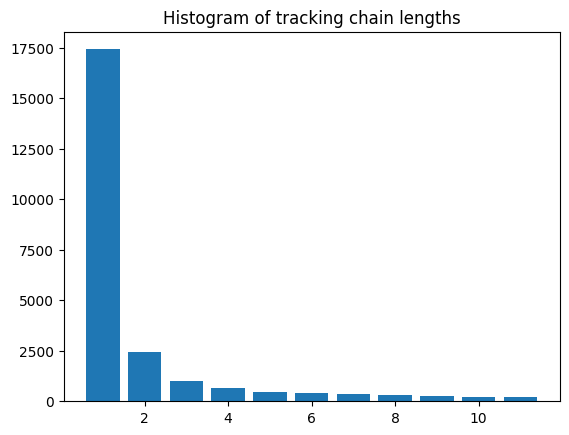

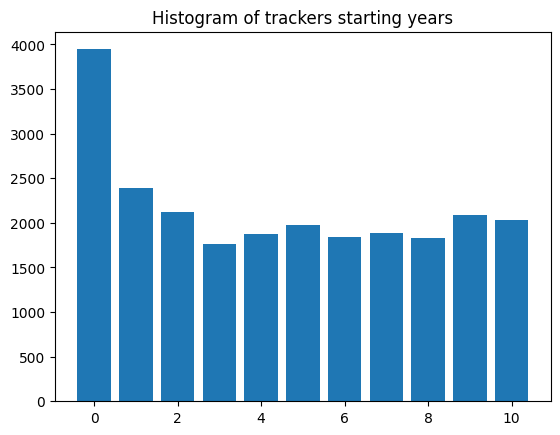

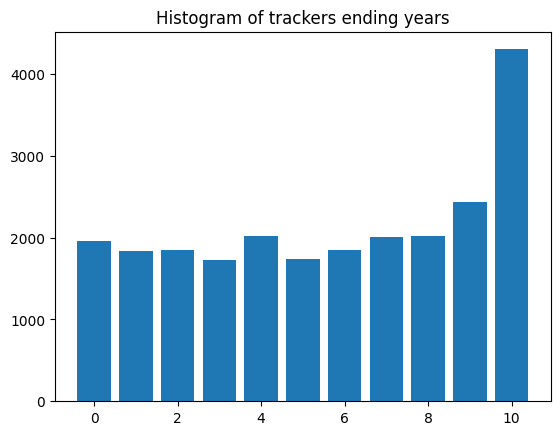

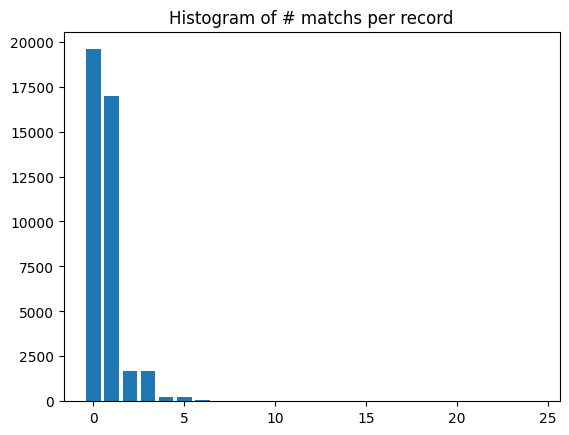

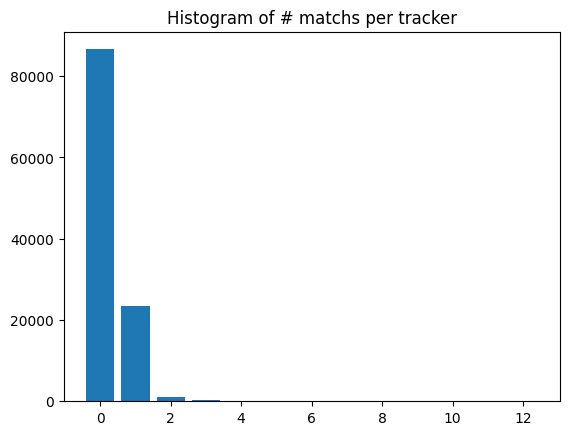

In [81]:
file_path = "base_config_35_45_06.beaver"
record_schema = record_schema_base
path = f"{beaver_folder_path}/{file_path}"
graph = bb.read_beaver(path)

summary_graph(graph, True, dataframes_35_45, record_schema_base, 11, 2)

In [82]:
file_path = "base_config_35_45_06.beaver"
path = f"{beaver_folder_path}/{file_path}"
graph = bb.read_beaver(path)

avg = None
i = 0
l = 0
id = 0
materialized = None
while avg is None or l < 5:
    id = graph.trackers_ids[i]
    avg = avg_distance_metrics(graph, dataframes_35_45, record_schema_base, id)
    materialized = graph.materialize_tracking_chain(
        id, dataframes_35_45, record_schema_base, None
    )
    l = len(materialized.matched_frames)
    i += 1


tracker_diag = graph.diagnostics.get_tracker(id)
for a in tracker_diag.frames:
    for r in a.records:
        print(r.distances)
print(avg)

[0.6666666269302368, 1.0, 0.2857142686843872, None, 1.0, 1.0, 0.8571428656578064]
[0.125, 1.0, 0.2857142686843872, 0.8888888955116272, 1.0, 0.1666666865348816, 0.8571428656578064]
[0.1111111044883728, 1.0, 0.3214285969734192, 1.0, 1.0, 0.1666666865348816, 0.8571428656578064]
[0.8333333134651184, 1.0, 0.6000000238418579, 1.0, 1.0, None, 1.0]
[0.434027761220932, 1.0, 0.3732142895460129, 0.9629629651705424, 1.0, 0.4444444576899211, 0.8928571492433548]


In [83]:
file_path = "base_config_35_45_06.beaver"
path = f"{beaver_folder_path}/{file_path}"
graph = bb.read_beaver(path)

print_verify_n_samples(graph, dataframes_35_45, record_schema_base, 10, 9)

Aggregated verifiers:
nom_rue: 0.6995810288409925
chef_prenom: 0.7993381240894435
chef_nom: 0.818264939309057
chef_origine: 0.8014663897036277
epouse_nom: 0.8196620906100073
chef_vocation: 0.6460369372386636


In [84]:
def manual_verifying(
    tracking_graph: bb.TrackingGraph,
    dataframes: list[pl.DataFrame],
    schema: RecordSchema,
    nb_samples: int,
    min_length: int,
):
    ids = take_n_random_ids(nb_samples, tracking_graph, min_length)
    a = []

    for id in ids:
        chain = tracking_graph.materialize_tracking_chain(
            id, dataframes, schema, normalized_dataframes=None
        )
        df = chain.as_dataframe().drop("frame_idx").drop("enfants_chez_parents_prenom")
        a.append([verify_column(df[col]) for col in df.columns])
        print_verify_df(chain)
        print()
        print(chain.as_dataframe())

    print_column_scores(tracking_graph, dataframes, schema)
    print()
    fields = []
    for f in schema.fields:
        fields.append(f.name)
    print_aggregate_verifiers(a, fields)


file_path = "weighted_config2_35_45_06.beaver"
record_schema = record_schema_base
path = f"{beaver_folder_path}/{file_path}"
graph = bb.read_beaver(path)
# manual_verifying(graph, record_schema, 10, 10)
verify_n_samples(graph, dataframes_35_45, record_schema, 1000, 10)
print()

file_path = "base_config_35_45_04.beaver"
record_schema = record_schema_base
path = f"{beaver_folder_path}/{file_path}"
graph = bb.read_beaver(path)
# manual_verifying(graph, record_schema, 10, 10)
verify_n_samples(graph, dataframes_35_45, record_schema, 1000, 10)

[0.5886224609637698,
 0.7847366071565454,
 0.7957656843064441,
 0.7344330143350979,
 0.6834192450387956,
 0.544229636017187]